# Parameter Tests $\lambda$ and $a$

In [68]:
# Importing pygimli
import  pygimli                 as     pg
import  pygimli.meshtools       as     mt
from    pygimli.physics         import ert
from    pygimli.physics         import TravelTimeManager
from    pygimli.viewer.mpl      import createColorBarOnly
from    JointEntropyClass       import JointEntropyInversion as JEI
from    pygimli.physics.gravimetry import GravityModelling2D

# Importing auxiliary libraries
import  numpy                   as     np
import  matplotlib.pyplot       as     plt
import  sys
import cmasher                     as cm

# Setting options
seed_val = 420
np.random.seed(seed_val)

# Filenames
fn_ert_dd  = 'Synth_ert_dd.dat'
fn_tt      = 'Synth_tt.dat'
fn_grav      = 'Synth_grav.npy'

# Plotting
c_ert = 'gnuplot'
c_srt = 'viridis'
c_grav = cm.pepper

lim_ert = [5e1, 1e4]
[r_left, r_right, r_back] = [7e1, 7e3, 7e2]
ert_label = ['Square', 'Circle', 'Half-space']

lim_srt = [300, 4200]
[v_left, v_right, v_layer1, v_layer2] = [3e3, 2e3, 5e2, 4e3]
srt_label = ['Square', 'Circle', 'Layer 1', 'Layer 2']

lim_grav = [0, 800]
[d_left, d_right, d_back] = [300, 750, 0]
grav_label = ['Square', 'Circle', 'Half-space']

## Data and Inversion Mesh

In [63]:
# Loading ERT
ert_data = ert.load(fn_ert_dd)
ERT = ert.ERTManager(ert_data)

# Loading SRT
tt_data = pg.physics.traveltime.load(fn_tt)
SRT = TravelTimeManager(tt_data)

grav_data = pg.Vector(np.load(fn_grav))

# inversion mesh
w = mt.createWorld([-65,-20], [65, 0])
for x in np.arange(-64,65,1):
    w.createNode([x,0])
invmesh = mt.createMesh(w,area=1.5)
extmesh = mt.appendTriangleBoundary(invmesh,xbound=100,ybound=100,marker=0)

# fig, ax = plt.subplots(1,3)
# ERT.showData(ert_data, ax=ax[0], cMap=c_ert)
# SRT.showData(tt_data, ax=ax[1], cMap=c_srt)
# pg.show(invmesh, ax=ax[2])

In [64]:
pnts_grav = np.array([np.linspace(-40,40,81) , np.zeros(81)]).T
fop = GravityModelling2D(mesh=invmesh, points=pnts_grav)
inv = pg.Inversion(fop=fop)
inv.setRegularization(limits=[-5, 800], trans="Cot")

startModel = pg.Vector(invmesh.cellCount(), 1)

rho = inv.run(grav_data, absoluteError=0.001, startModel=startModel, lam=1, verbose=True, cType=1, dPhi=0.001, isReference=True)

26/07/23 - 13:02:51 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:02:51 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216184C0B30>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000021654A914C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransCotLU object at 0x00000216533BFF40>
min/max (data): 0.0029/0.09
min/max (error): 1.16%/35.08%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1494.97 (dPhi = 9.69%) lam: 1
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1349.42 (dPhi = 9.7%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1101.21 (dPhi = 18.28%) lam: 1.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 758.11 (dPhi = 30.98%) lam: 1.0
----------------------

(-40.0, 40.0)

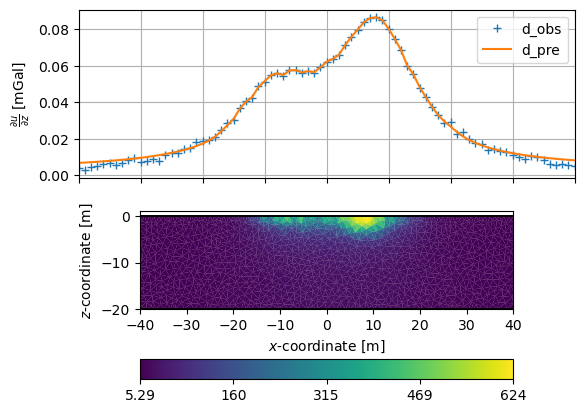

In [52]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(pnts_grav[:,0], grav_data, "+", label='d_obs')
ax[0].plot(pnts_grav[:,0], inv.response, "-", label='d_pre')
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(invmesh, rho, ax=ax[1], logScale=False)
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-20, 1))
ax[1].set_xlim((-40, 40))

## Set order $q$ for following calculations

<div class="alert alert-success">
    
Change the $q$ accordingly, depending if you want to reproduce first or second order expressions.

In [72]:
q = 2

## ME GRAV lambda and smoothing tests

In [74]:
a_list = [0, 25, 100]#[10, 25, 100]
lam_list = [1e-5, 1e-3, 1e-2] 
beta = 1e-10

dRho_me = []
tit  = []

for a in a_list:
    for lam in lam_list:
        pnts_grav = np.array([np.linspace(-40,40,81) , np.zeros(81)]).T
        fop = GravityModelling2D(mesh=invmesh, points=pnts_grav)
        inv = pg.Inversion(fop=fop)
        inv.setRegularization(limits=[0, 800])#, trans="Cot")
        GRAV = pg.frameworks.methodManager.MethodManager(fop=fop, fw=inv, data=grav_data)
        
        Je = JEI(mgr_list=[GRAV], data_list=[grav_data], mesh=invmesh, order=q, beta=beta, smooth_factor=a)
        
        startModel = pg.Vector(invmesh.cellCount(), 1)
        KWe = dict(lam=lam, verbose=True, startModel=startModel)
        Je.setKWInv([KWe])
        Je.setNames(['GRAV'])

        Je.runInversion('ME', maxIter=20, chi_limit=1)

        [dRho_est] = Je.getModels()
        
        dRho_me.append(dRho_est)
        tit.append(f'lam={lam}, a={a}')

26/07/23 - 13:22:19 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:19 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:19 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216544DEA40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000216524B07C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0FA0>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1277.56 (dPhi = 85.8%) lam: 1e-05
Starting iteration 1...


26/07/23 - 13:22:20 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:20 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 1194.13
#####     stabilizing functional    S = 7.79
#####     joint weighted misfit chi^2 = 1194.13
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 916.27
#####     stabilizing functional    S = 7.81
#####     joint weighted misfit chi^2 = 916.27
############################################################
       
Starting iteration 3...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 680.45
#####     stabilizing functional    S = 7.61
#####     joint weighted misfit chi^2 = 680.45
############################################################
       
Starting iteration 4...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 496.82
#####     stabilizing functional    S = 7.48
##

26/07/23 - 13:22:27 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:27 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:27 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:22:27 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:27 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216395C00E0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002164F1A0E20>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0FA0>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1259.21 (dPhi = 86.0%) lam: 0.001
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 1119.80
#####     stabilizing functional    S = 7.37
#####     joint weighted misfit chi^2 = 1119.80
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2

26/07/23 - 13:22:35 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:35 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:35 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:22:35 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:35 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216395C0130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002164F1A0F40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0E20>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4572.58 (dPhi = 49.17%) lam: 0.01
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2   = 6153.95
#####     stabilizing functional    S = 0.37
#####     joint weighted misfit chi^2 = 6153.95
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=0
#####     GRAV weighted misfit chi^2

26/07/23 - 13:22:43 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:43 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:43 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x0000021657AA4CC0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000021639C94460>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0E20>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1277.56 (dPhi = 85.8%) lam: 1e-05
Starting iteration 1...


26/07/23 - 13:22:43 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:43 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 1193.64
#####     stabilizing functional    S = 7.83
#####     joint weighted misfit chi^2 = 1193.64
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 904.75
#####     stabilizing functional    S = 7.90
#####     joint weighted misfit chi^2 = 904.75
############################################################
       
Starting iteration 3...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 834.18
#####     stabilizing functional    S = 7.71
#####     joint weighted misfit chi^2 = 834.18
############################################################
       
Starting iteration 4...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 755.35
#####     stabilizing functional    S = 7.7

26/07/23 - 13:22:51 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:51 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:51 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:22:51 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:51 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x0000021639B80400>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000021639C94460>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000216524B07C0>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1259.21 (dPhi = 86.0%) lam: 0.001
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 1129.78
#####     stabilizing functional    S = 9.44
#####     joint weighted misfit chi^2 = 1129.78
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi

26/07/23 - 13:22:57 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:22:57 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:22:57 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:22:57 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:22:57 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216395C0130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000216524B07C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0E20>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4572.58 (dPhi = 49.17%) lam: 0.01
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit chi^2   = 4198.61
#####     stabilizing functional    S = 11.29
#####     joint weighted misfit chi^2 = 4198.61
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=25
#####     GRAV weighted misfit ch

26/07/23 - 13:23:04 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:23:04 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:23:04 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x0000021657AA4CC0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002164F1A0EE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0F40>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1277.56 (dPhi = 85.8%) lam: 1e-05
Starting iteration 1...


26/07/23 - 13:23:04 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:23:04 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 1195.64
#####     stabilizing functional    S = 8.21
#####     joint weighted misfit chi^2 = 1195.64
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 844.20
#####     stabilizing functional    S = 9.31
#####     joint weighted misfit chi^2 = 844.20
############################################################
       
Starting iteration 3...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 747.21
#####     stabilizing functional    S = 7.97
#####     joint weighted misfit chi^2 = 747.21
############################################################
       
Starting iteration 4...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 634.73
#####     stabilizing functional    S =

26/07/23 - 13:23:13 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:23:13 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:23:13 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:23:13 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:23:13 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216395C0A40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000216524B07C0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0E80>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 1259.21 (dPhi = 86.0%) lam: 0.001
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 1017.14
#####     stabilizing functional    S = 10.47
#####     joint weighted misfit chi^2 = 1017.14
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit 

26/07/23 - 13:23:21 - pyGIMLi - WARNING - No data error given, set Fallback set to 1%
26/07/23 - 13:23:21 - pyGIMLi - INFO - Starting inversion.
26/07/23 - 13:23:21 - pyGIMLi - INFO - Setting starting model as reference!
26/07/23 - 13:23:21 - pyGIMLi - INFO - Use median(data values)=0.02094283046510902
26/07/23 - 13:23:21 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [0.02094283046510902,...,0.02094283046510902]


Starting Iteration 0...
... GRAV
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x00000216395C0950>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002164F1A0F40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002164F1A0E20>
min/max (data): 0.0029/0.09
min/max (error): 1%/1%
min/max (start model): 1/1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 4572.58 (dPhi = 49.17%) lam: 0.01
Starting iteration 1...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit chi^2   = 4277.85
#####     stabilizing functional    S = 8.90
#####     joint weighted misfit chi^2 = 4277.85
############################################################
       
Starting iteration 2...
Set JME weights for GRAV with q=2, b=1e-10 and a=100
#####     GRAV weighted misfit c

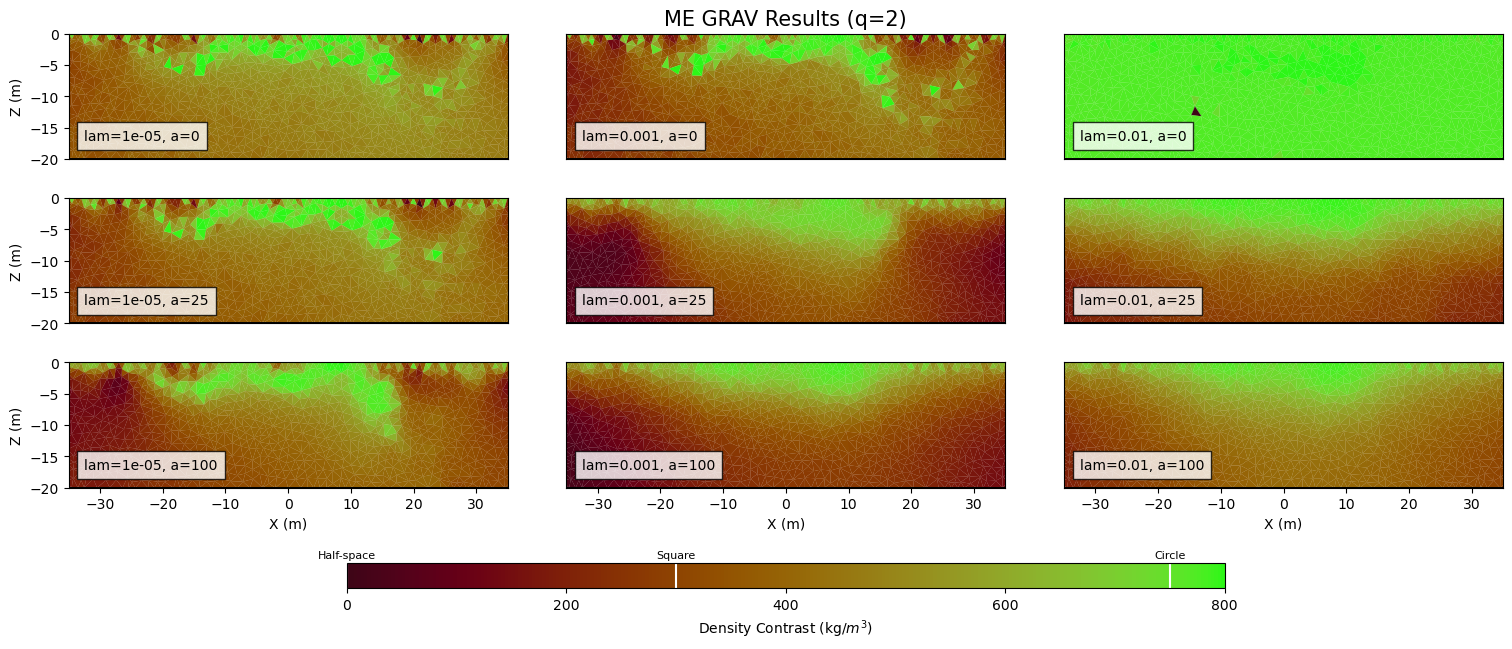

In [75]:
fig, ax = plt.subplots(3,3, figsize=(15,5))
fig.tight_layout(pad=0.5)
ax[0,1].set_title(f'ME GRAV Results (q={q})', fontsize = 15)
for i in np.arange(3):
    for j in np.arange(3):
        pg.show(invmesh, dRho_me[i*3+j], ax=ax[i,j], 
                cMap=c_grav, cMin=lim_grav[0], cMax=lim_grav[1], 
                colorBar=False, logScale=True)
        
        ax[i,j].text(-32.5, -17, tit[i*3+j], fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
        ax[i,j].set_xlim(-35,35)
        ax[i,j].set_ylim(-20,0)

# Adjust axis labels
for axis in ax[:,0]:
    axis.set_ylabel('Z (m)')
for axis in ax[-1,:]:
    axis.set_xlabel('X (m)')
for axis_ar in ax[:2,:]:
    for axis in axis_ar:
        axis.set_xticks([])
for axis_ar in ax[:,1:]:
    for axis in axis_ar:
        axis.set_yticks([])

# Add colorbar
cax = ax[2,1].inset_axes([-0.5, -0.8, 2, 0.2])
createColorBarOnly(ax=cax, cMin=lim_grav[0], cMax=lim_grav[1], logScale=True,cMap=c_grav,
                  label='Density Contrast (kg/$m^3$)', orientation='horizontal')
for i, d in enumerate([d_left, d_right,d_back]):
    cax.plot([d]*2, [0,1], 'w')
    cax.text(d, 1.3, grav_label[i], fontsize=8, horizontalalignment='center', verticalalignment='center')
    

## ME ERT lambda and smoothing tests

In [53]:
a_list = [0, 25, 100]
lam_list = [1e-5, 1e-3, 1e-1] 
beta = 1e-10

r_me = []
tit  = []

for a in a_list:
    for lam in lam_list:
        ERT2 = ert.ERTManager(ert_data)
        Je = JEI(mgr_list=[ERT2], data_list=[ert_data], mesh=invmesh, order=q, beta=beta, smooth_factor=a)

        KWe = dict(lam=lam, verbose=False)
        Je.setKWInv([KWe])
        Je.setNames(['ERT'])
        Je.setMethodMesh(extmesh, 0)

        Je.runInversion('ME', maxIter=10, chi_limit=1)
        ERT2.showResultAndFit(cMap=c_ert)

        [r_est] = Je.getModels()
        
        r_me.append(r_est)
        tit.append(f'lam={lam}, a={a}')

26/07/23 - 12:58:33 - pyGIMLi - INFO - Found 2 regions.
26/07/23 - 12:58:33 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.
26/07/23 - 12:58:33 - pyGIMLi - INFO - Creating forward mesh from region infos.


Starting Iteration 0...
... ERT


26/07/23 - 12:58:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
26/07/23 - 12:58:33 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 7632 Cells: 14948 Boundaries: 11368
26/07/23 - 12:58:34 - pyGIMLi - INFO - Use median(data values)=619.288890298902
26/07/23 - 12:58:34 - pyGIMLi - INFO - Created startmodel from forward operator: 2979 [619.288890298902,...,619.288890298902]
26/07/23 - 12:58:34 - pyGIMLi - INFO - Setting starting model as reference!


KeyboardInterrupt: 

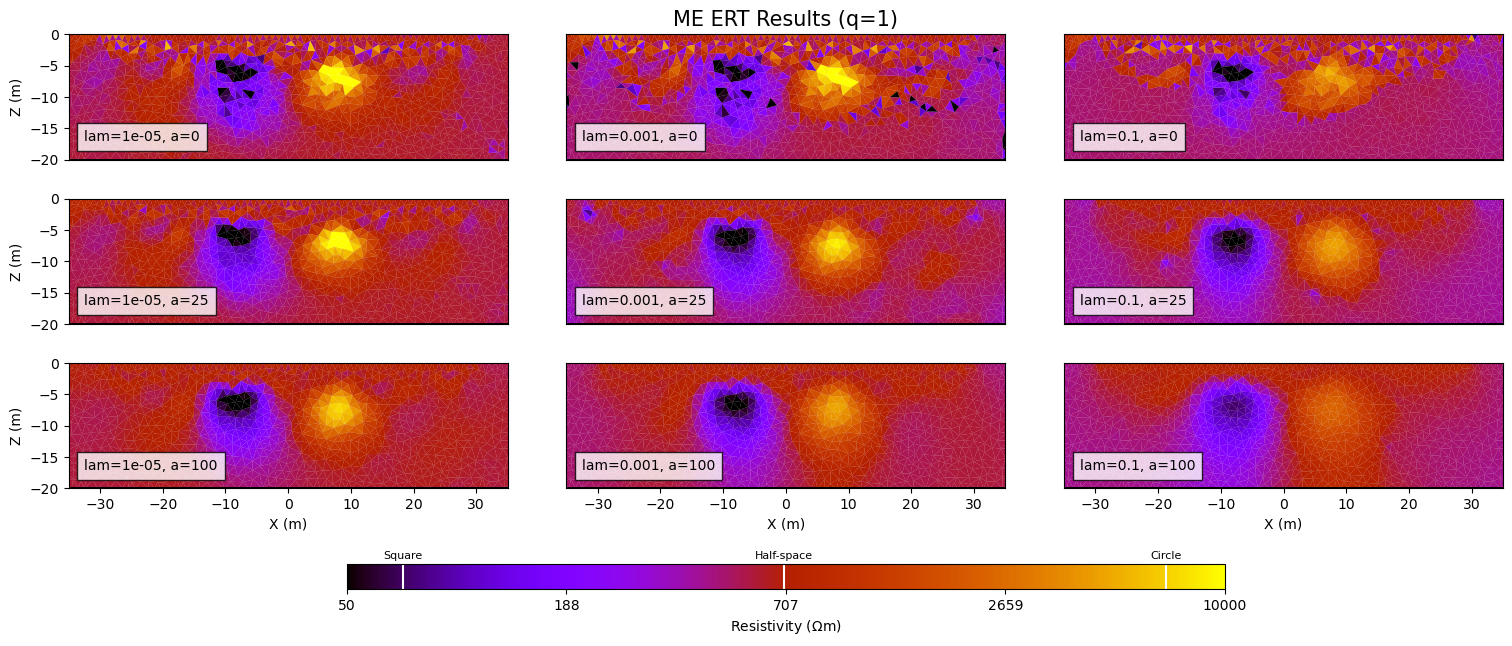

In [5]:
fig, ax = plt.subplots(3,3, figsize=(15,5))
fig.tight_layout(pad=0.5)
ax[0,1].set_title(f'ME ERT Results (q={q})', fontsize = 15)
for i in np.arange(3):
    for j in np.arange(3):
        pg.show(invmesh, r_me[i*3+j], ax=ax[i,j], 
                cMap=c_ert, cMin=lim_ert[0], cMax=lim_ert[1], 
                colorBar=False, logScale=True)
        
        ax[i,j].text(-32.5, -17, tit[i*3+j], fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
        ax[i,j].set_xlim(-35,35)
        ax[i,j].set_ylim(-20,0)

# Adjust axis labels
for axis in ax[:,0]:
    axis.set_ylabel('Z (m)')
for axis in ax[-1,:]:
    axis.set_xlabel('X (m)')
for axis_ar in ax[:2,:]:
    for axis in axis_ar:
        axis.set_xticks([])
for axis_ar in ax[:,1:]:
    for axis in axis_ar:
        axis.set_yticks([])

# Add colorbar
cax = ax[2,1].inset_axes([-0.5, -0.8, 2, 0.2])
createColorBarOnly(ax=cax, cMin=lim_ert[0], cMax=lim_ert[1], logScale=True,cMap=c_ert,
                  label=pg.unit('res'), orientation='horizontal')
for i, r in enumerate([r_left, r_right,r_back]):
    cax.plot([r]*2, [0,1], 'w')
    cax.text(r, 1.3, ert_label[i], fontsize=8, horizontalalignment='center', verticalalignment='center')
    
# plt.savefig(f'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-4/Comp_ME_lam_a_q{q}_ERT.pdf', 
#             bbox_inches='tight',
#            dpi=600)

## ME SRT lambda and smoothing tests

31/05/23 - 20:41:55 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:41:55 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:41:55 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:41:55 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:41:55 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:41:55 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 635.83
#####     stabilizing functional    S = 4.45
#####     joint weighted misfit chi^2 = 635.83
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 303.27
#####     stabilizing functional    S = 7.88
#####     joint weighted misfit chi^2 = 303.27
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 154.11
#####     stabilizing functional    S = 5.22
#####     joint weighted misfit chi^2 = 154.11
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 53.87
##

31/05/23 - 20:43:13 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:43:13 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:43:13 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:43:13 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:43:13 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:43:13 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 636.61
#####     stabilizing functional    S = 4.43
#####     joint weighted misfit chi^2 = 636.61
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 309.01
#####     stabilizing functional    S = 7.88
#####     joint weighted misfit chi^2 = 309.01
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 141.18
#####     stabilizing functional    S = 7.41
#####     joint weighted misfit chi^2 = 141.18
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 51.90
##

31/05/23 - 20:44:45 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:44:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:44:45 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:44:45 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:44:45 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:44:45 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 1059.67
#####     stabilizing functional    S = 1.13
#####     joint weighted misfit chi^2 = 1059.67
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 288.94
#####     stabilizing functional    S = 3.77
#####     joint weighted misfit chi^2 = 288.94
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 42.68
#####     stabilizing functional    S = 8.89
#####     joint weighted misfit chi^2 = 42.68
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=0
#####     SRT weighted misfit chi^2   = 14.80
##

31/05/23 - 20:46:58 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:46:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:46:58 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:46:58 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:46:58 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:46:58 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 607.09
#####     stabilizing functional    S = 4.47
#####     joint weighted misfit chi^2 = 607.09
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 280.07
#####     stabilizing functional    S = 8.05
#####     joint weighted misfit chi^2 = 280.07
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 127.46
#####     stabilizing functional    S = 7.10
#####     joint weighted misfit chi^2 = 127.46
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 36.8

31/05/23 - 20:48:40 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:48:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:48:40 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:48:40 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:48:40 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:48:40 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 157.41
#####     stabilizing functional    S = 10.38
#####     joint weighted misfit chi^2 = 157.41
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 84.74
#####     stabilizing functional    S = 5.10
#####     joint weighted misfit chi^2 = 84.74
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 52.27
#####     stabilizing functional    S = 12.36
#####     joint weighted misfit chi^2 = 52.27
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 16.24


31/05/23 - 20:51:04 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:51:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:51:04 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:51:04 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:51:04 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:51:04 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 150.99
#####     stabilizing functional    S = 23.43
#####     joint weighted misfit chi^2 = 150.99
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 74.05
#####     stabilizing functional    S = 3.37
#####     joint weighted misfit chi^2 = 74.05
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 42.19
#####     stabilizing functional    S = 25.01
#####     joint weighted misfit chi^2 = 42.19
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=50
#####     SRT weighted misfit chi^2   = 23.43


31/05/23 - 20:53:30 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:53:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:53:31 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:53:31 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:53:31 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:53:31 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 274.98
#####     stabilizing functional    S = 3.50
#####     joint weighted misfit chi^2 = 274.98
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 64.01
#####     stabilizing functional    S = 9.41
#####     joint weighted misfit chi^2 = 64.01
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 39.75
#####     stabilizing functional    S = 4.69
#####     joint weighted misfit chi^2 = 39.75
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 21.2

31/05/23 - 20:55:10 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:55:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:55:10 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:55:10 - pyGIMLi - INFO - Create gradient starting model. 500: 4500
31/05/23 - 20:55:10 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:55:10 - pyGIMLi - INFO - Setting starting model as reference!


Starting Iteration 0...
... SRT
Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 177.11
#####     stabilizing functional    S = 20.83
#####     joint weighted misfit chi^2 = 177.11
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 79.88
#####     stabilizing functional    S = 4.05
#####     joint weighted misfit chi^2 = 79.88
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 42.42
#####     stabilizing functional    S = 21.84
#####     joint weighted misfit chi^2 = 42.42
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 22

31/05/23 - 20:57:38 - pyGIMLi - INFO - Found 1 regions.
31/05/23 - 20:57:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/05/23 - 20:57:38 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
31/05/23 - 20:57:38 - pyGIMLi - INFO - Create gradient starting model. 500: 4500


Starting Iteration 0...
... SRT


31/05/23 - 20:57:38 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00194971 0.0010641  0.00194971 ... 0.00023161 0.0002245  0.00024393]
31/05/23 - 20:57:38 - pyGIMLi - INFO - Setting starting model as reference!


Starting iteration 1...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 118.85
#####     stabilizing functional    S = 68.10
#####     joint weighted misfit chi^2 = 118.85
############################################################
       
Starting iteration 2...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 40.06
#####     stabilizing functional    S = 7.02
#####     joint weighted misfit chi^2 = 40.06
############################################################
       
Starting iteration 3...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 12.98
#####     stabilizing functional    S = 7.33
#####     joint weighted misfit chi^2 = 12.98
############################################################
       
Starting iteration 4...
Set JME weights for SRT with q=2, b=1e-10 and a=200
#####     SRT weighted misfit chi^2   = 5.77
#####     stabilizing function

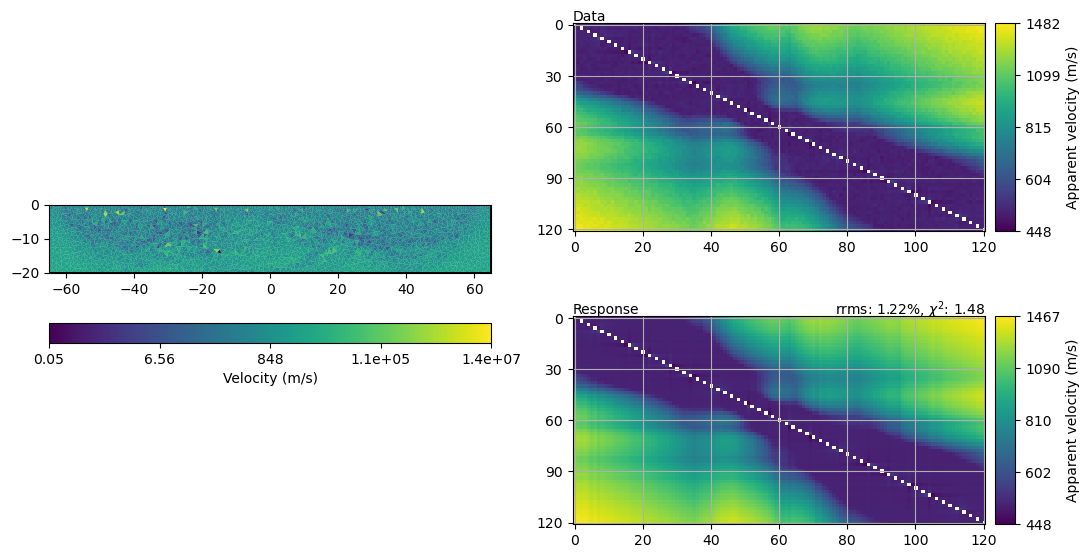

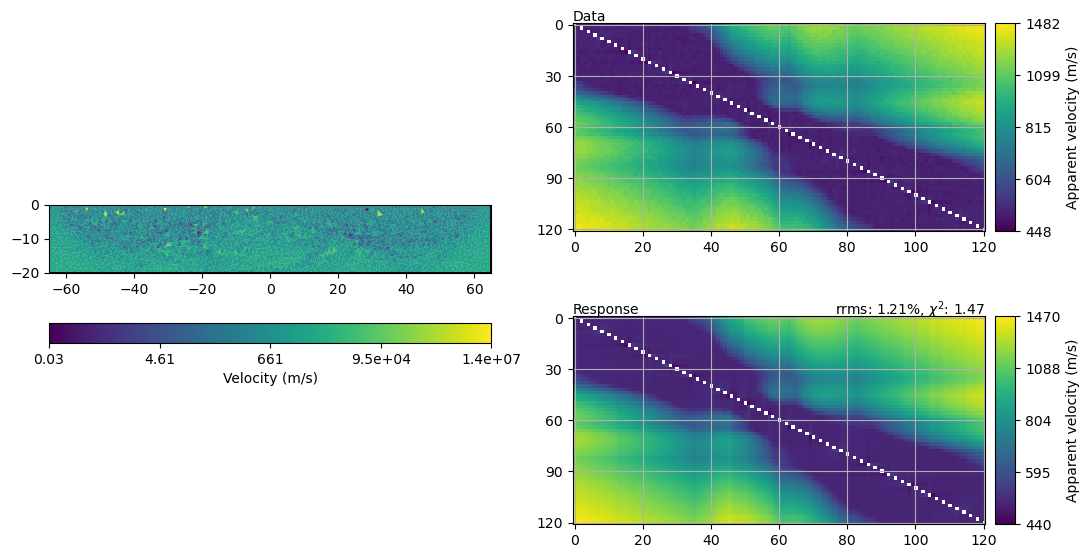

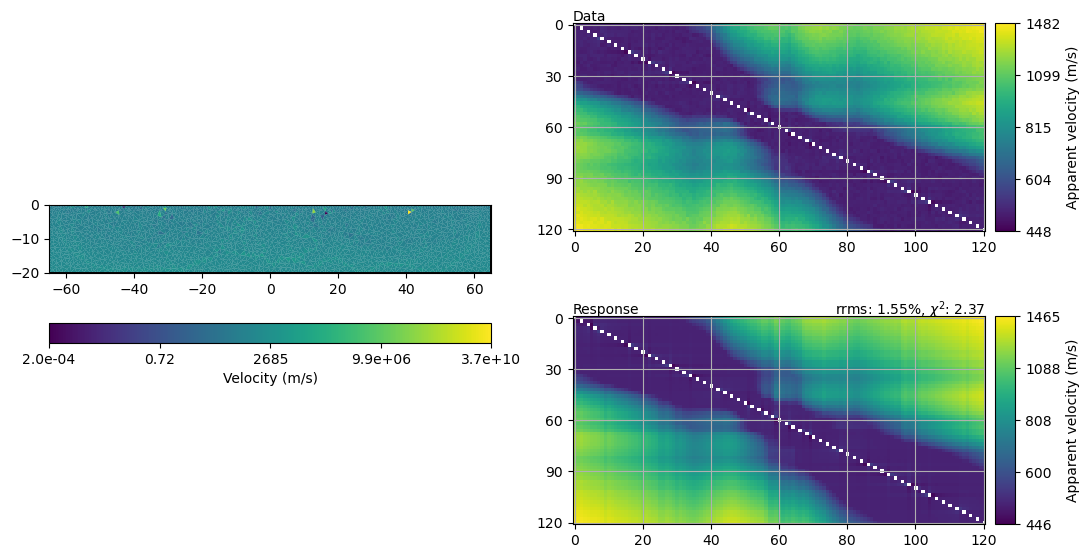

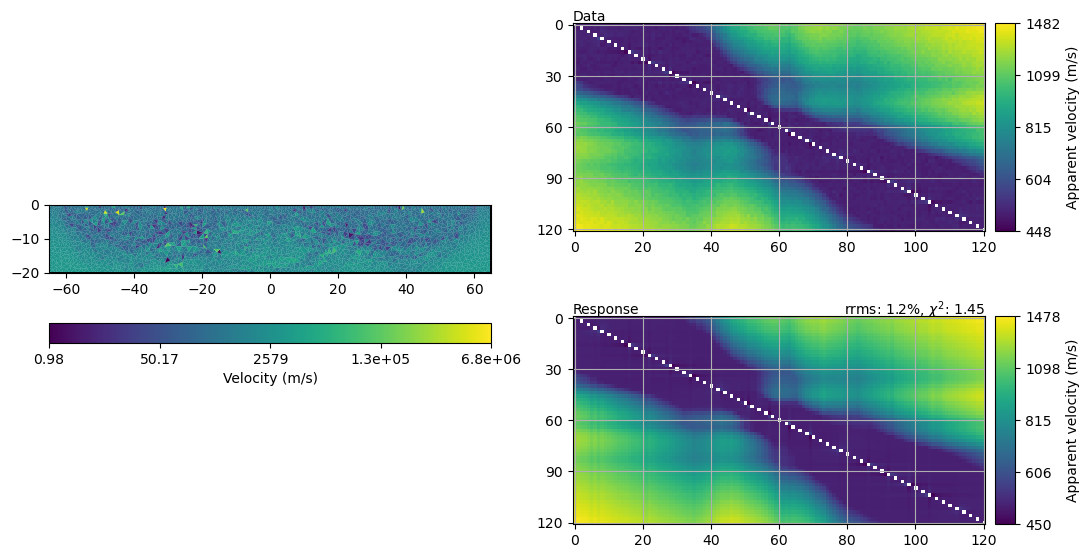

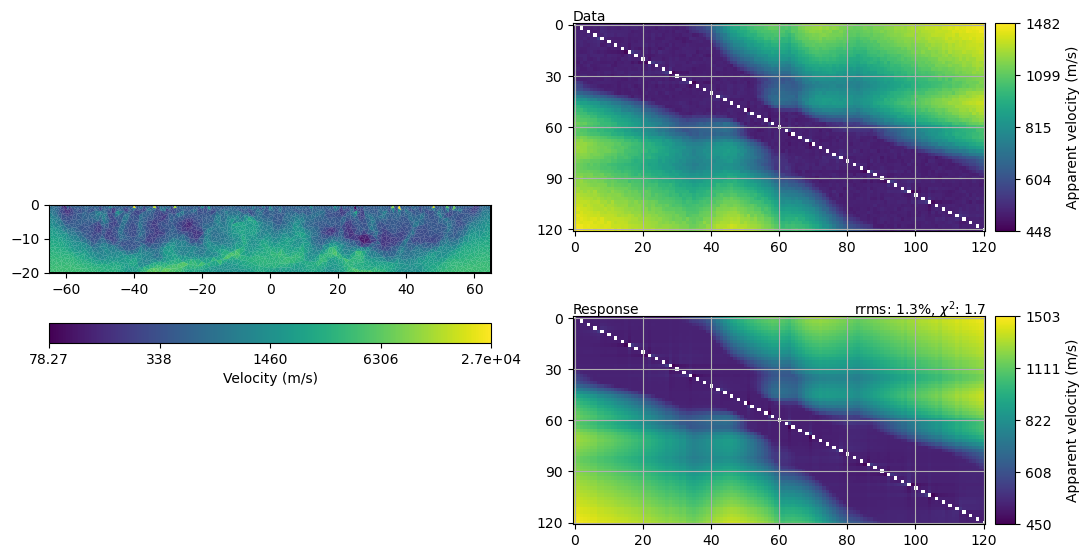

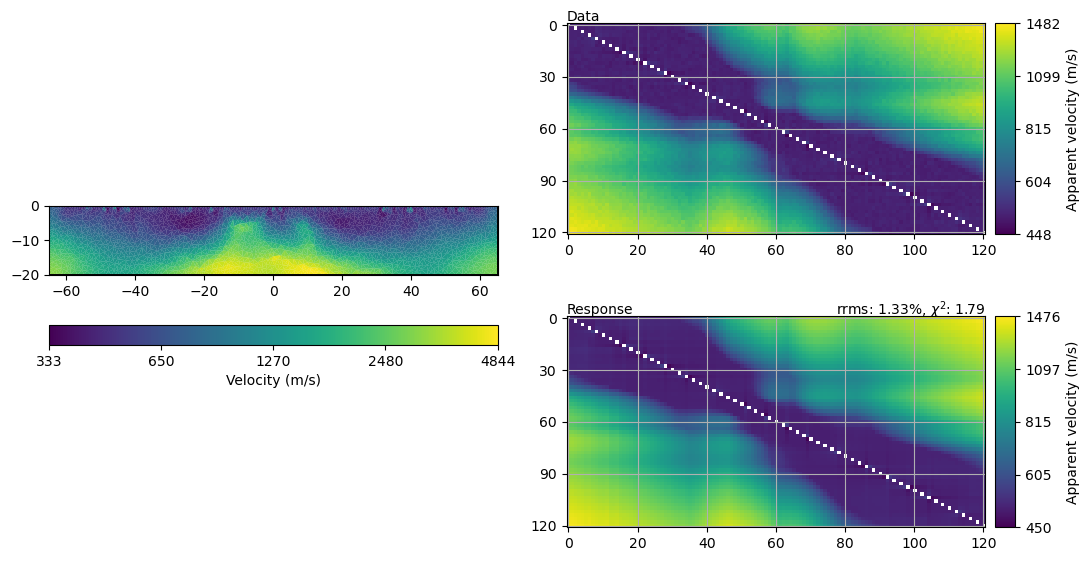

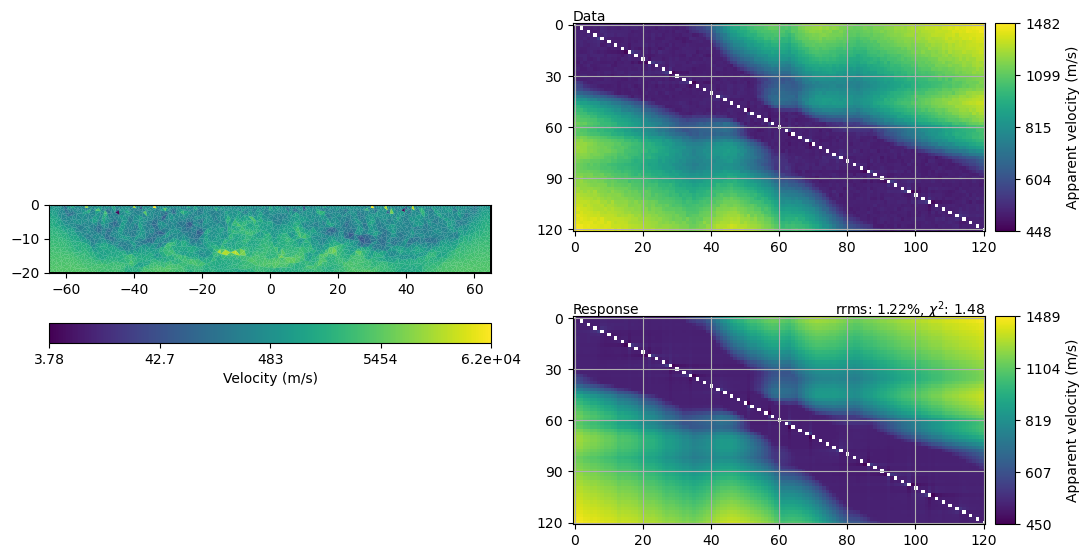

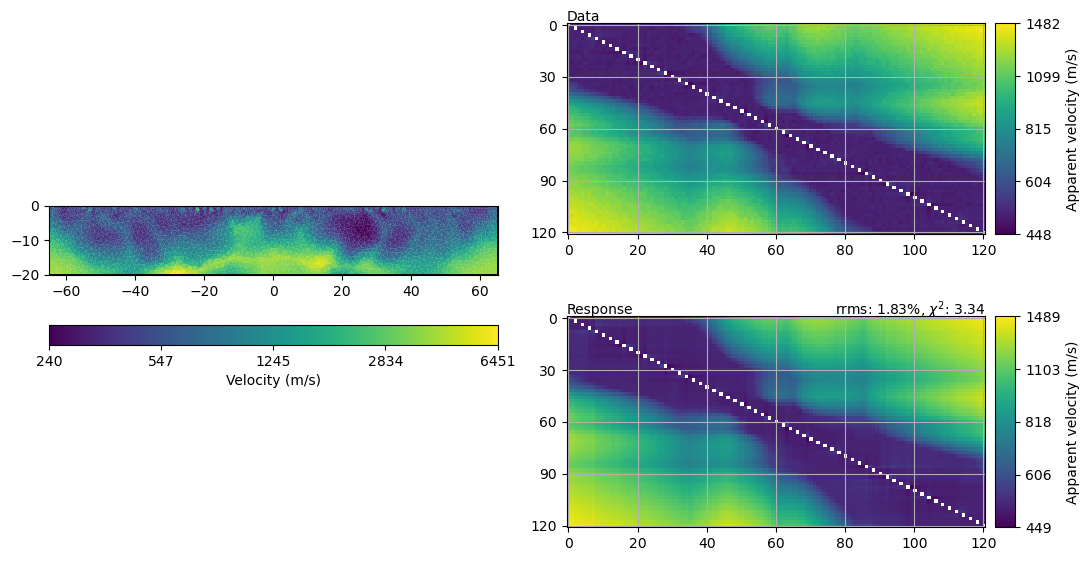

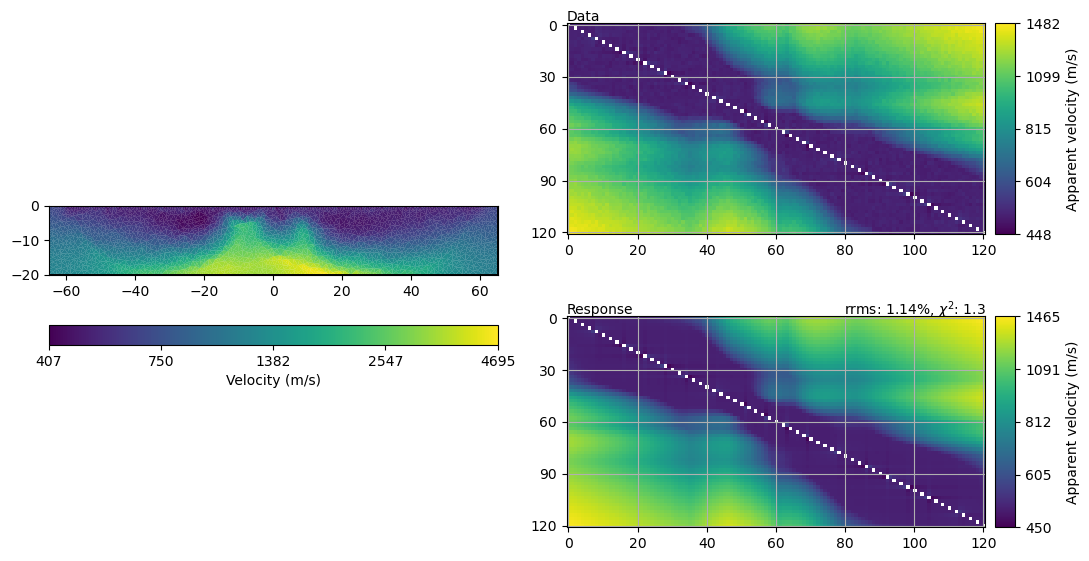

In [15]:
a_list = [0, 50, 200]
lam_list = [1e-5, 1e-3, 1e-1] 
beta = 1e-10

v_me = []
tit  = []

for a in a_list:
    for lam in lam_list:
        SRT2 = TravelTimeManager(tt_data)
        Js = JEI(mgr_list=[SRT2], data_list=[tt_data], mesh=invmesh, order=q, beta=beta, smooth_factor=a)

        KWs = dict(lam=lam, verbose=False, vTop=500, vBottom=4500, secNodes=1)
        Js.setKWInv([KWs])
        Js.setNames(['SRT'])

        Js.runInversion('ME', maxIter=20, chi_limit=1.5)
        SRT2.inv.model = 1/SRT2.inv.model
        SRT2.showResultAndFit(cMap=c_srt)

        [v_est] = Js.getModels()
        
        v_me.append(v_est)
        tit.append(f'lam={lam}, a={a}')

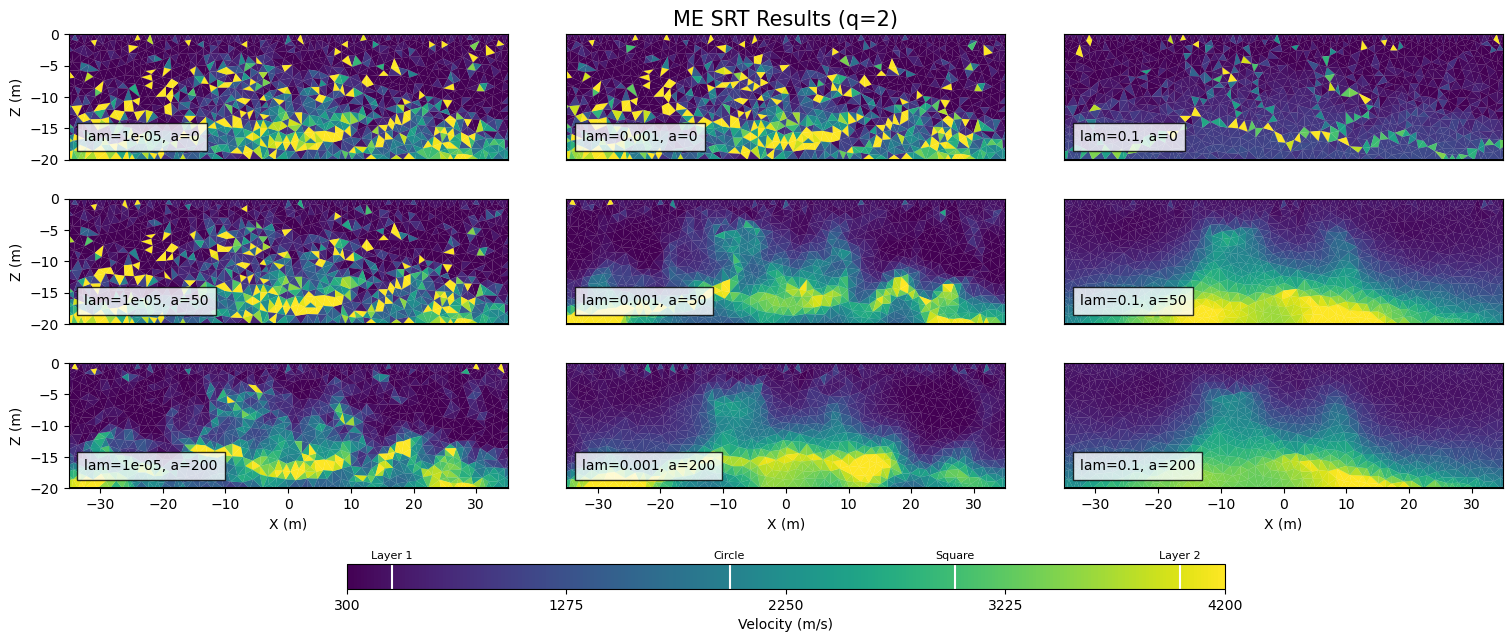

In [16]:
fig, ax = plt.subplots(3,3, figsize=(15,5))
fig.tight_layout(pad=0.5)
ax[0,1].set_title(f'ME SRT Results (q={q})', fontsize = 15)
for i in np.arange(3):
    for j in np.arange(3):
        pg.show(invmesh, v_me[i*3+j], ax=ax[i,j], 
                cMap=c_srt, cMin=lim_srt[0], cMax=lim_srt[1], 
                colorBar=False, logScale=False)
        
        ax[i,j].text(-32.5, -17, tit[i*3+j], fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
        ax[i,j].set_xlim(-35,35)
        ax[i,j].set_ylim(-20,0)

# Adjust axis labels
for axis in ax[:,0]:
    axis.set_ylabel('Z (m)')
for axis in ax[-1,:]:
    axis.set_xlabel('X (m)')
for axis_ar in ax[:2,:]:
    for axis in axis_ar:
        axis.set_xticks([])
for axis_ar in ax[:,1:]:
    for axis in axis_ar:
        axis.set_yticks([])

# Add colorbar
cax = ax[2,1].inset_axes([-0.5, -0.8, 2, 0.2])
createColorBarOnly(ax=cax, cMin=lim_srt[0], cMax=lim_srt[1], logScale=False,cMap=c_srt,
                  label=pg.unit('vel'), orientation='horizontal')
for i, v in enumerate([v_left, v_right, v_layer1, v_layer2]):
    cax.plot([v]*2, [0,1], 'w')
    cax.text(v, 1.3, srt_label[i], fontsize=8, horizontalalignment='center', verticalalignment='center')

# plt.savefig(f'C:/Users/azieg/Desktop/GIT_repositories/APG-MSc-Project-Ziegon/Figures/Ch-4/Comp_ME_lam_a_q{q}_SRT.pdf', 
#             bbox_inches='tight',
#             dpi=600)